In [2]:
!pip install yfinance
!pip install arch # Autoregressive Conditional Heteroskedasticity (ARCH)
!pip install lppls # Log Periodic Power Law Singularity (LPPLS) Model

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 45 kB 2.1 MB/s 
     |████████████████████████████████| 249 kB 9.1 MB/s 


In [52]:
import pandas as pd
import numpy as np
import seaborn as sns
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.stats.descriptivestats as descriptivestats

import matplotlib
import warnings

from matplotlib import style
from datetime import datetime, timedelta
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from sklearn.metrics import mean_squared_error
from scipy.stats import probplot, moment
from arch import arch_model
from arch.univariate import ConstantMean, GARCH, Normal

matplotlib.style.use('grayscale')
warnings.filterwarnings('ignore')

## Index overview

### Getting the data

Freely available structured data for the greek stock market indices are not easy to come by - especially nowadays with the excellent `investpy` library being [out of commission](https://github.com/alvarobartt/investpy/issues/600) at least for the foreseeable future.

Fortunately several greek finance online publications maintain tables of daily prices and OHLC data. In this instace we use a csv file published by capital.gr (link [link text](https://www.capital.gr/finance/historycloses/ftse?page=1)) which is updated a couple hours after market close time (~ 19:00 - 20:00 EET).

The data available cover the period from 01/01/1995 - today, however we are focusing on the the index evolution since 2017.



In [4]:
# get FTSE25 data from capital.gr (https://www.capital.gr/finance/historycloses/ftse?page=1)
# note that the key param of the url below might be different - check it against the link above!
data = pd.read_csv('https://www.capital.gr/finance/quotes/exporthistorycloses?symbol=ftse&key=-1373644113', skiprows = 1, decimal=",")  

# remove columns we are not using
del data['ΜΕΤ.%']
del data['Τζίρος']

# convert date to date format
data['Ημ/νία'] = pd.to_datetime(data['Ημ/νία'], format="%d/%m/%Y")

# rename columns to en
data.columns = ['date', 'close', 'open', 'high', 'low', 'volume']

# make date index
data.set_index('date', inplace = True)

# convert volume column from string to float
data['volume'] = data['volume'].str.replace(".","").astype(float)

# rearrange columns
data = data[['open', 'high', 'low', 'close', 'volume']]

# keep data from 01/01/2017 and sort ascending
data = data[(data.index > "2017-01-01")].sort_index(ascending=True)

# check for missing values (this will be included in the QC section of the final pipeline for the daily ingested data along with the other quality checks)
data.isnull().sum()

# view a sample
print(data)

               open     high      low      close      volume
date                                                        
2017-01-02  1741.46  1753.04  1740.67  1744.9400  18213258.0
2017-01-03  1750.98  1778.75  1745.83  1769.6900  68663545.0
2017-01-04  1778.02  1780.06  1763.24  1773.8400  52684044.0
2017-01-05  1773.71  1773.94  1752.64  1773.9400  66179243.0
2017-01-09  1773.62  1773.81  1751.83  1769.7400  31669813.0
...             ...      ...      ...        ...         ...
2022-09-26  1908.19  1927.38  1881.06  1904.2000  13750969.0
2022-09-27  1923.99  1939.19  1918.11  1918.1100  18292863.0
2022-09-28  1902.70  1919.46  1876.47  1899.5700  19235792.0
2022-09-29  1899.99  1913.71  1891.97  1894.0699  13045188.0
2022-09-30  1898.92  1914.45  1897.85  1904.4500  19823453.0

[1425 rows x 5 columns]


### Data processing
Create columns for:


1.   daily absolute percentage change,
2.   standard deviation of return,
3.   daily, monthly and annualized historical volatility.



In [9]:
# calculate daily absolute daily return, logarithmic return, daily, monthly and annual historical volatility
data['absReturn'] = data['close'].pct_change(1).dropna().mul(100)
data['logReturn'] = np.log(data['close']).diff().dropna().mul(100)
data['dailyVol'] = data['logReturn'].std()
data['monthlyVol'] = data['logReturn'].rolling(window = 21).std()*np.sqrt(21)
data['annualVol'] = data['logReturn'].rolling(window = 252).std()*np.sqrt(252)

In [10]:
# print last ten trading days
data.tail(10)

,open,high,low,close,volume,absReturn,logReturn,dailyVol,monthlyVol,annualVol
date,,,,,,,,,,
2022-09-19,1998.29,2012.87,1990.7300,2008.2000,7564332.0,-0.225067,-0.225321,1.622944,5.310282,24.136687
2022-09-20,2015.44,2032.17,2014.6200,2016.7600,12637873.0,0.426252,0.425346,1.622944,5.371573,24.135092
2022-09-21,1997.25,2003.47,1977.9600,1993.3400,16333726.0,-1.161269,-1.168064,1.622944,5.430813,24.161077
2022-09-22,1969.91,1994.72,1968.9700,1968.9700,13403880.0,-1.222571,-1.230106,1.622944,5.487567,24.189381
2022-09-23,1965.10,1974.28,1912.9301,1916.2500,21076374.0,-2.677542,-2.714041,1.622944,5.848214,24.322171
2022-09-26,1908.19,1927.38,1881.0600,1904.2000,13750969.0,-0.628832,-0.630818,1.622944,5.840781,24.319907
2022-09-27,1923.99,1939.19,1918.1100,1918.1100,18292863.0,0.730490,0.727835,1.622944,5.367761,24.223199
2022-09-28,1902.70,1919.46,1876.4700,1899.5700,19235792.0,-0.966576,-0.971278,1.622944,5.265385,24.239271
2022-09-29,1899.99,1913.71,1891.9700,1894.0699,13045188.0,-0.289544,-0.289964,1.622944,5.250601,24.240263


### Descriptive statistics for the daily closing price
We use `descriptivestats` from the [`statsmodels`](https://www.statsmodels.org/dev/generated/statsmodels.stats.descriptivestats.Description.html#statsmodels.stats.descriptivestats.Description) library for the closing price vector:

In [24]:
# descriptive statistics for the daily close price
print(descriptivestats.Description(data['close']).summary())

  Descriptive Statistics  
nobs                  1425
missing                  0
mean                  1961
std_err             0.1723
upper_ci              1961
lower_ci              1960
std                  245.5
iqr                  359.5
iqr_normal           266.5
mad                  204.4
mad_normal           256.1
coef_var            0.1252
range                 1200
max                   2376
min                   1176
skew               -0.7356
kurtosis             2.617
jarque_bera          137.2
jarque_bera_pval 1.592e-30
mode                  1550
mode_freq         0.001404
median                2028
--------------------------


In [25]:
# descriptive statistics for the daily log return
print(descriptivestats.Description(data['logReturn']).summary())

  Descriptive Statistics  
nobs                  1425
missing                  1
mean              0.006143
std_err            0.00114
upper_ci          0.008377
lower_ci          0.003909
std                  1.623
iqr                  1.487
iqr_normal           1.102
mad                  1.062
mad_normal           1.331
coef_var             264.2
range                26.62
max                  11.67
min                 -14.95
skew                -1.079
kurtosis             17.79
jarque_bera      1.325e+04
jarque_bera_pval         0
mode                -14.95
mode_freq        0.0007022
median              0.1049
--------------------------


In [ ]:
# Calculate daily std of return
daily_volatility = data['log_return'].std()

# Convert daily volatility to monthly volatility
monthly_volatility  = np.sqrt(21) * daily_volatility

# Convert daily volatility to annual volatility
annual_volatility = np.sqrt(252) * daily_volatility

print(f'Daily volatility: {round(daily_volatility,2)}%')
print(f'\nMonthly volatility: {round(monthly_volatility,2)}%')
print(f'\nAnnualized volatility: {round(annual_volatility,2)}%')

Daily volatility: 1.62%

Monthly volatility: 7.44%

Annualized volatility: 25.76%


### Visualizations
FTSE/Athex Large Cap close values, daily log returns, annualized volatility and histogram of log returns:

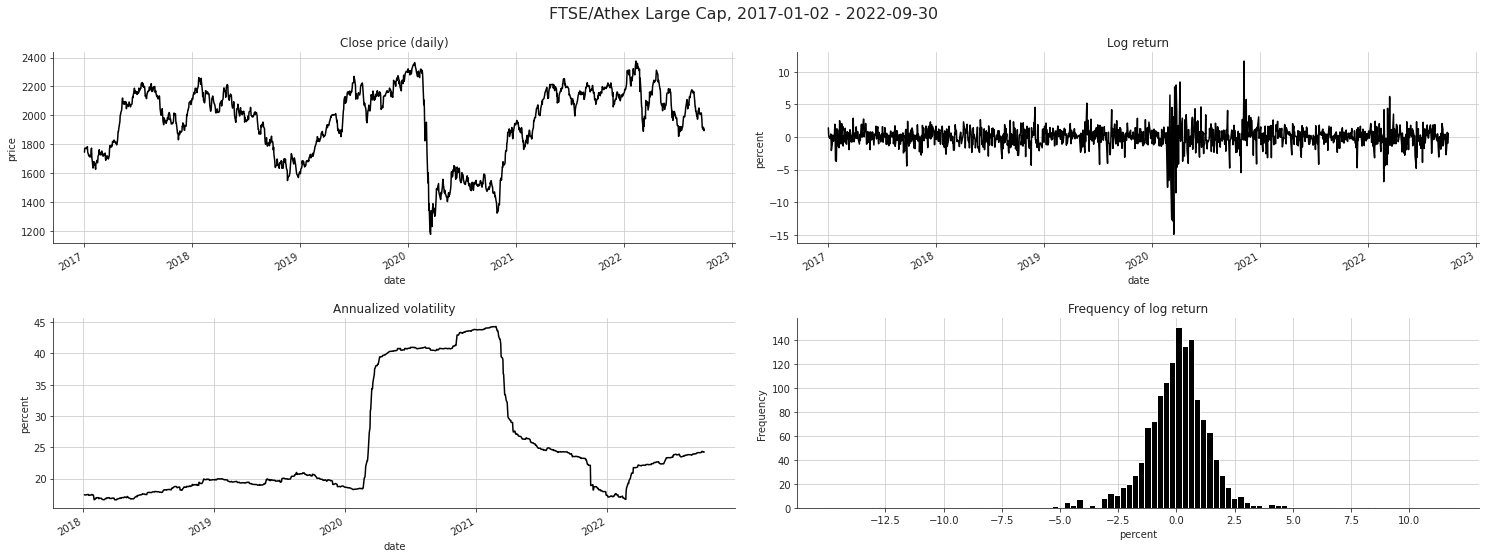

In [123]:
sns.set_style("ticks",{'axes.grid' : True})

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(21, 8))
data['close'].plot(ax=axes[0][0], title="Close price (daily)").set_ylabel('price')
data['logReturn'].plot(ax=axes[0][1], title="Log return").set_ylabel('percent')
data['annualVol'].plot(ax=axes[1][0], title="Annualized volatility").set_ylabel('percent')
data['logReturn'].plot.hist(bins=100, ax=axes[1][1], title="Frequency of log returns").set_xlabel('percent')

axes[1][1].set_xticks(np.arange(-12.5, 12.5, 2.5))

fig.suptitle(f"FTSE/Athex Large Cap, {datetime.date(data.index.min())} - {datetime.date(data.index.max())}", fontsize=16)
sns.despine()
fig.tight_layout(pad=2)
fig.subplots_adjust(top=.9)

In [162]:
adfuller(data['logReturn'].rolling(21).mean().dropna())

(-5.094263221303963,
 1.4396177634796633e-05,
 24,
 1379,
 {'1%': -3.4351009168670035,
  '5%': -2.863638180853028,
  '10%': -2.5678870681532424},
 -2618.455142714024)

In [131]:
data['annualVol'].mean()

25.040995060580265

In [165]:
def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(21, 8))
    x.plot(ax=axes[0][0], title='Residuals')
    x.rolling(21).mean().plot(ax=axes[0][0], c='red', lw=1)
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat:{np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
    axes[0][0].text(x=.02, y=.85, s=stats,horizontalalignment='left', verticalalignment='baseline', transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis: {kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=14)
    sns.despine()
    fig.tight_layout(pad=2)
    fig.subplots_adjust(top=.9)


### ACF / PACF of log returns

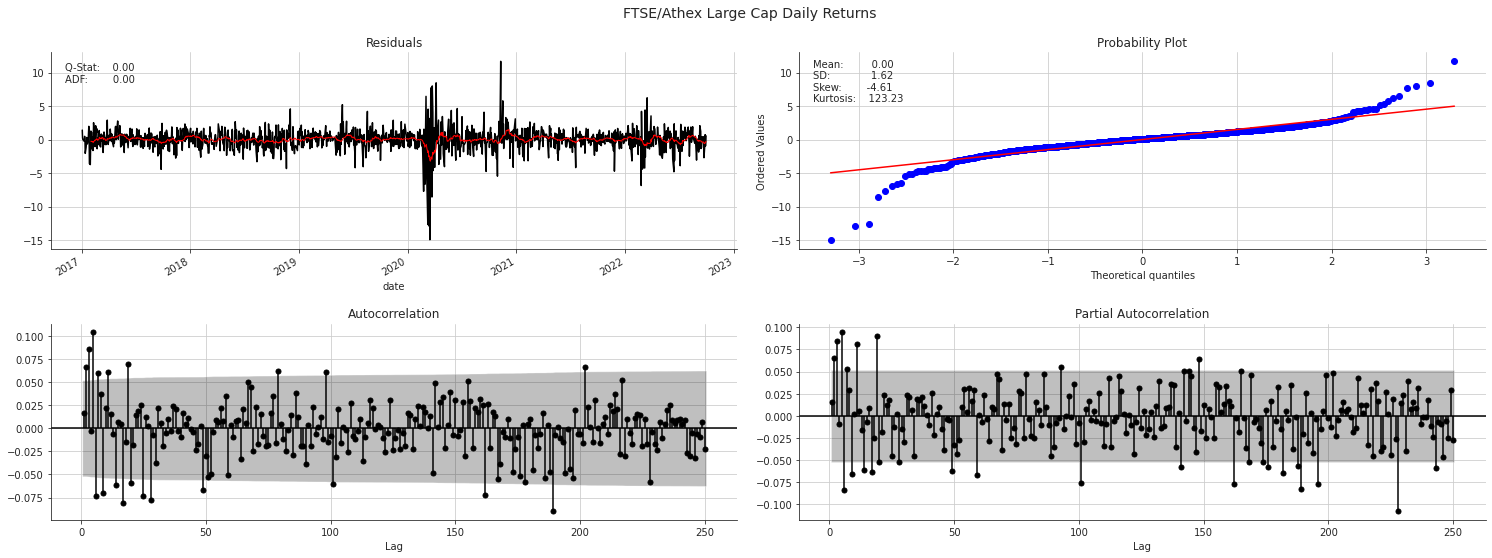

In [166]:
plot_correlogram(data['logReturn'].dropna(), lags=250, title='FTSE/Athex Large Cap Daily Returns')

### ACF / PACF of residuals

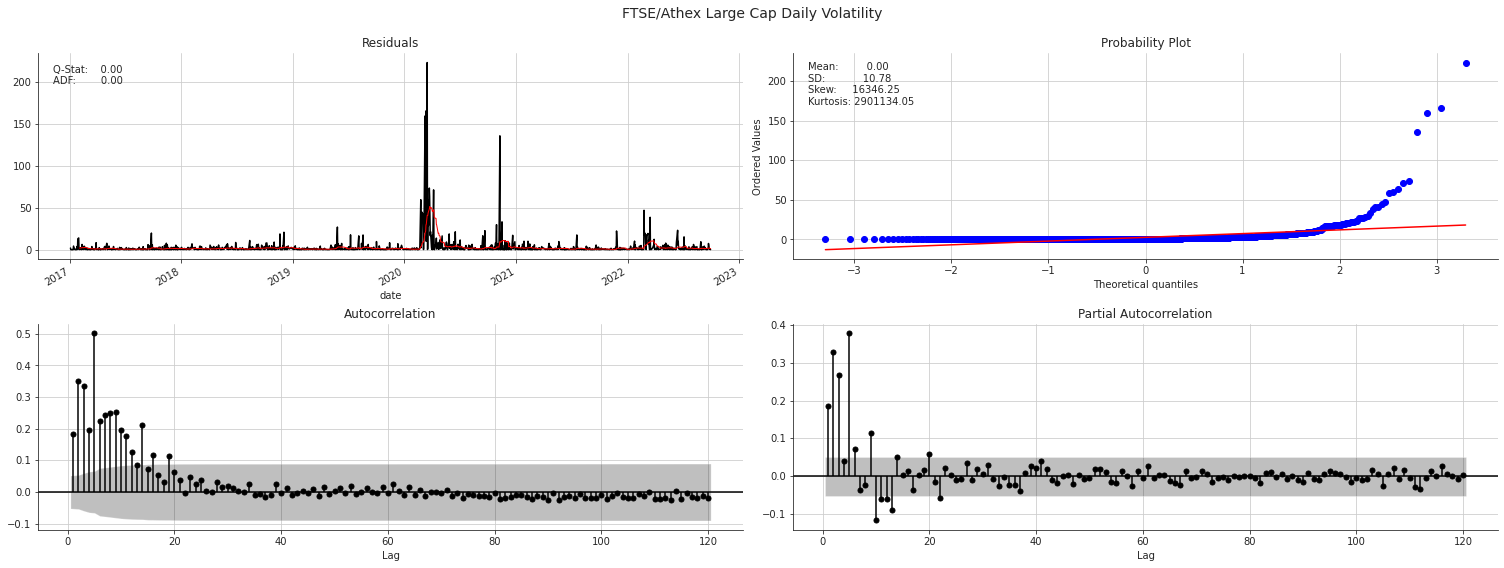

In [164]:
plot_correlogram(data['logReturn'].dropna().sub(data['logReturn'].mean()).pow(2), lags=120, title='FTSE/Athex Large Cap Daily Volatility')

## GARCH model
One step ahaed forecast


In [ ]:
trainsize = 1 * 252  # 1 year
data2 = data['log_return'].dropna().clip(lower=data['log_return'].dropna().quantile(.05), upper=data['log_return'].dropna().quantile(.95))
T = len(data.dropna())
results = {}
for p in range(1, 5):
    for q in range(1, 5):
        print(f'{p} | {q}')
        result = []
        for s, t in enumerate(range(trainsize, T-1)):
            train_set = data2.iloc[s: t]
            test_set = data2.iloc[t+1]  # 1-step ahead forecast
            model = arch_model(y=train_set, p=p, q=q).fit(disp='off')
            forecast = model.forecast(horizon=1)
            mu = forecast.mean.iloc[-1, 0]
            var = forecast.variance.iloc[-1, 0]
            result.append([(test_set-mu)**2, var])
        df = pd.DataFrame(result, columns=['y_true', 'y_pred'])
        results[(p, q)] = np.sqrt(mean_squared_error(df.y_true, df.y_pred))

1 | 1
1 | 2
1 | 3
1 | 4
2 | 1
2 | 2
2 | 3
2 | 4
3 | 1
3 | 2
3 | 3
3 | 4
4 | 1
4 | 2
4 | 3
4 | 4


In [ ]:
s = pd.Series(results)
s.index.names = ['p', 'q']
s = s.unstack().sort_index(ascending=False)


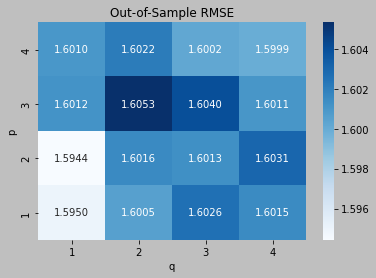

In [ ]:
sns.heatmap(s, cmap='Blues', annot=True, fmt='.4f')
plt.title('Out-of-Sample RMSE');


In [ ]:
best_p, best_q = 1, 1,

am = ConstantMean(data['log_return'].dropna().clip(lower=data['log_return'].dropna().quantile(.05),
                                      upper=data['log_return'].dropna().quantile(.95)))
am.volatility = GARCH(best_p, 0, best_q)
am.distribution = Normal()
best_model = am.fit(update_freq=5)
print(best_model.summary())


Iteration:      5,   Func. Count:     39,   Neg. LLF: 2174.9343594314864
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2174.8611182042264
            Iterations: 8
            Function evaluations: 55
            Gradient evaluations: 8
                     Constant Mean - GARCH Model Results                      
Dep. Variable:             log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2174.86
Distribution:                  Normal   AIC:                           4357.72
Method:            Maximum Likelihood   BIC:                           4378.77
                                        No. Observations:                 1424
Date:                Sun, Oct 02 2022   Df Residuals:                     1423
Time:                        18:24:35   Df Model:                            1
        

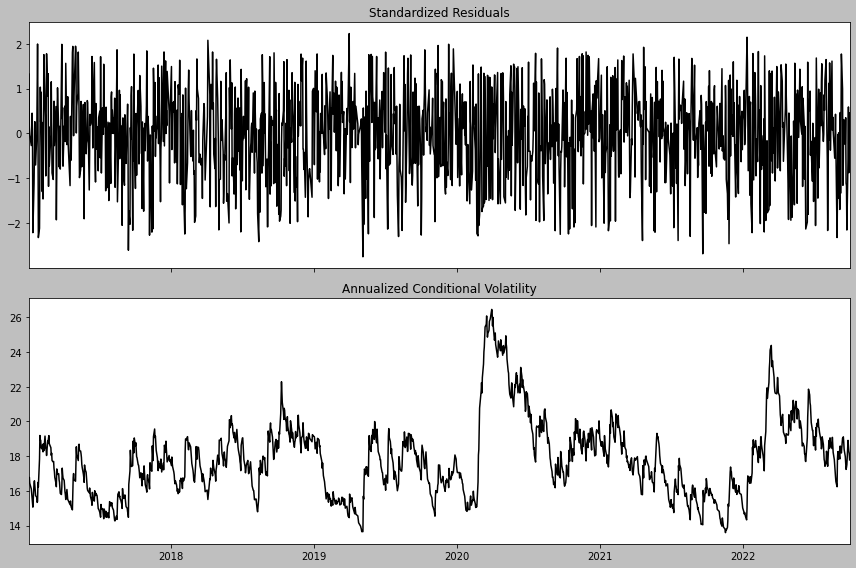

In [ ]:
fig = best_model.plot(annualize='D')
fig.set_size_inches(12, 8)
fig.tight_layout();

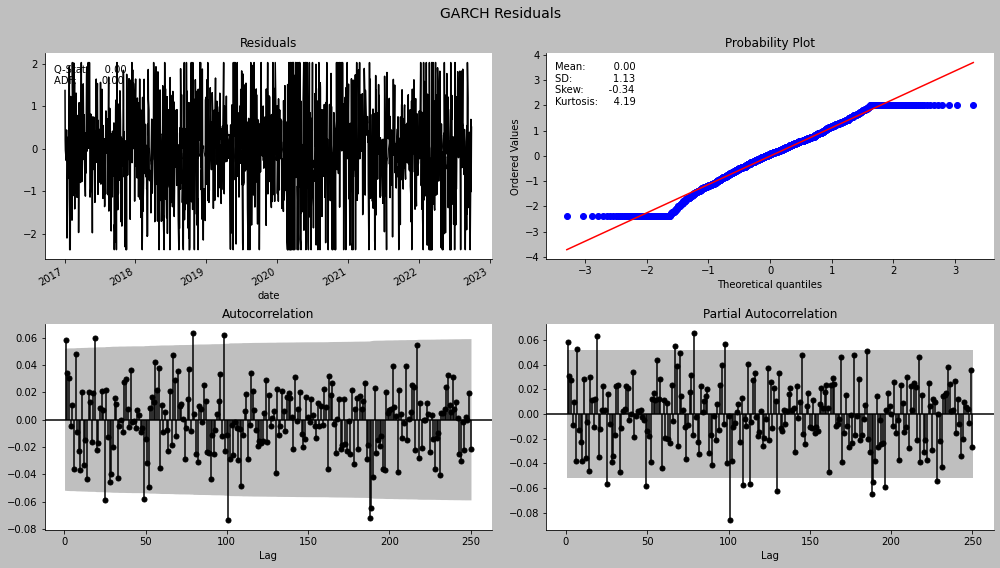

In [ ]:
plot_correlogram(best_model.resid.dropna(),
                 lags=250,
                 title='GARCH Residuals')

In [ ]:
am

Constant Mean(constant: yes, no. of exog: 0, volatility: GARCH(p: 1, q: 1), distribution: Normal distribution), id: 0x7fb2cb706790

In [ ]:
forecasts = best_model.forecast(horizon=5, reindex=False)
print(forecasts.residual_variance.iloc[-3:])


                 h.1       h.2       h.3       h.4       h.5
date                                                        
2022-09-30  1.210426  1.212379  1.214274  1.216111  1.217894


In [ ]:
forecasts.residual_variance

,h.1,h.2,h.3,h.4,h.5
date,,,,,
2022-09-30,1.210426,1.212379,1.214274,1.216111,1.217894


In [ ]:
print(forecasts.variance)

                 h.1       h.2       h.3       h.4       h.5
date                                                        
2022-09-30  1.210426  1.212379  1.214274  1.216111  1.217894


In [ ]:
# line plot
def generatePlot(data, xlabel, ylabel, title, subtitle):

    fig, ax = plt.subplots(figsize=(16,8))

    sns.lineplot(
        alpha = 0.75,
        data = data,
        ax = ax
    )

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    locator = mdates.MonthLocator(bymonth=[4,7,10])
    ax.xaxis.set_minor_locator(locator)
    ax.xaxis.set_minor_formatter(mdates.ConciseDateFormatter(locator))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))

    ax.set_xlim([datetime.date(data.index.min() - timedelta(days = 30)), datetime.date(data.index.max() + timedelta(days = 30))])

    ax.text(x=0.5, y=1.1, s = title, fontsize=30, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
    ax.text(x=0.5, y=1.05, s = subtitle, fontsize=18, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)
    fig.tight_layout()
    plt.show()

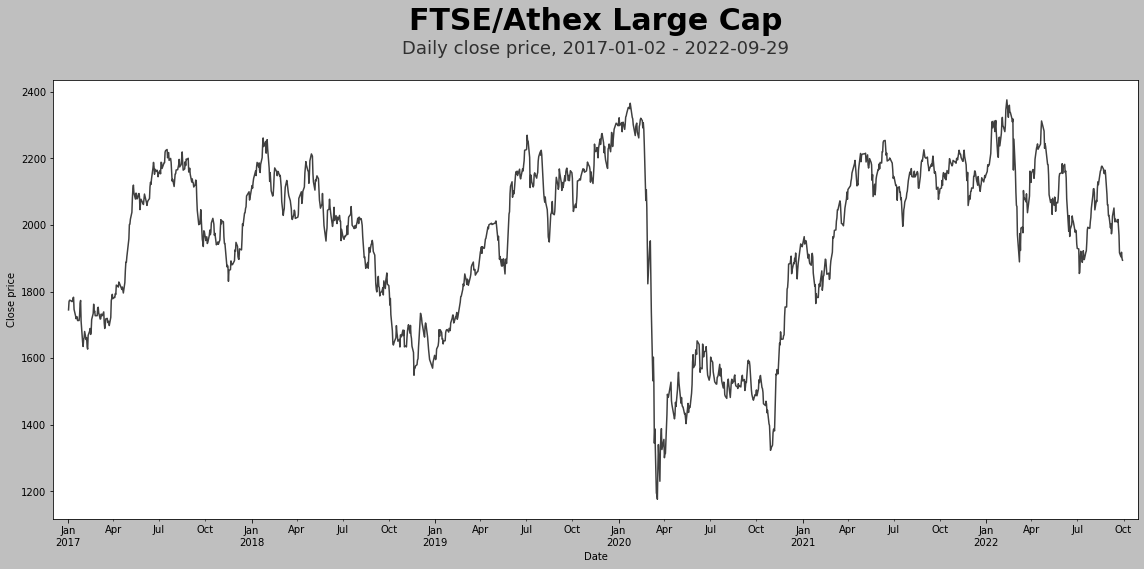

In [ ]:
generatePlot(data['close'], 'Date', 'Close price', 'FTSE/Athex Large Cap', f"Daily close price, {datetime.date(data.index.min())} - {datetime.date(data.index.max())}")

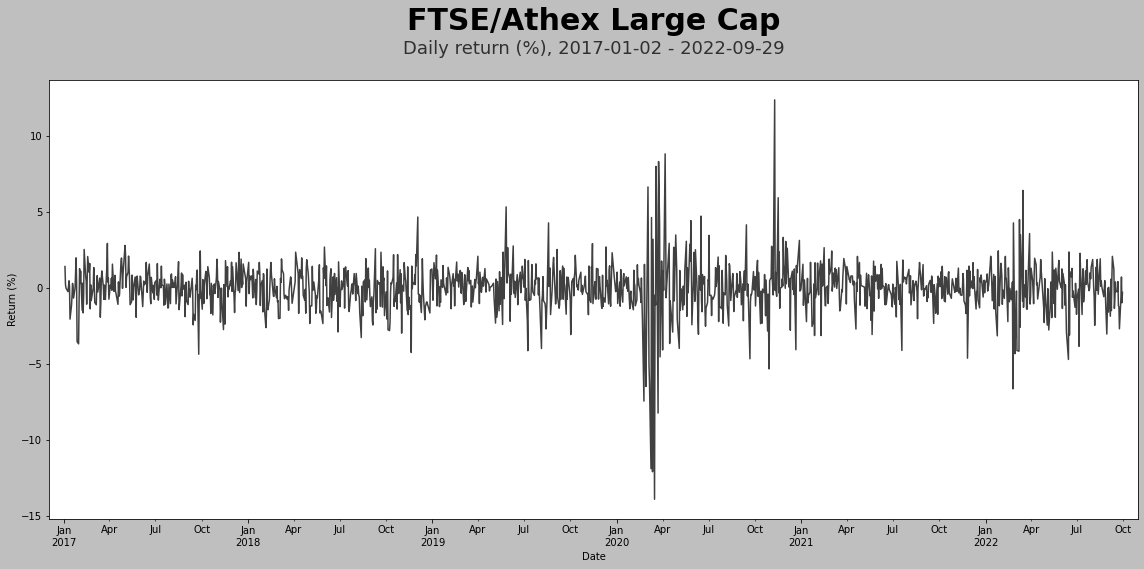

In [ ]:
generatePlot(data['abs_return'], 'Date', 'Return (%)', 'FTSE/Athex Large Cap', f"Daily return (%), {datetime.date(data.index.min())} - {datetime.date(data.index.max())}")

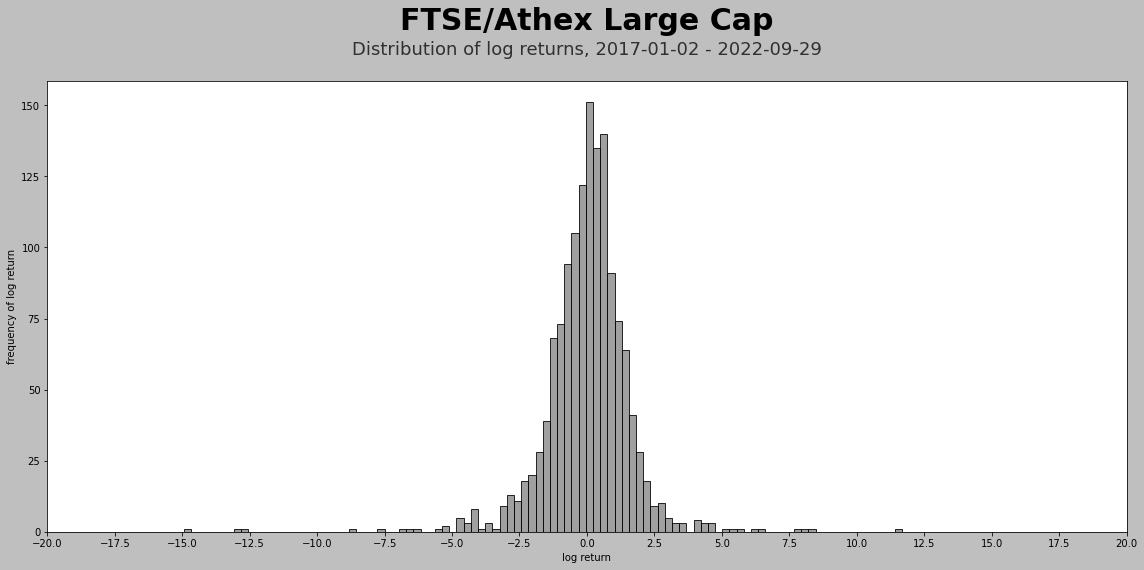

In [ ]:
# histogram of log returns

matplotlib.style.use('grayscale')

fig, ax = plt.subplots(figsize=(16,8))

sns.histplot(
    alpha=0.75,
    data=data['log_return'],
    bins=100,
    ax=ax
)

ax.set_xlabel('log return')
ax.set_ylabel('frequency of log return')

ax.set_yticks(np.arange(0, 175, 25))
ax.set_xticks(np.arange(-20, 22.5, 2.5))

ax.text(x=0.5, y=1.1, s='FTSE/Athex Large Cap', fontsize=30, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
ax.text(x=0.5, y=1.05, s=f"Distribution of log returns, {datetime.date(data.index.min())} - {datetime.date(data.index.max())}", fontsize=18, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)

fig.tight_layout()
plt.show()

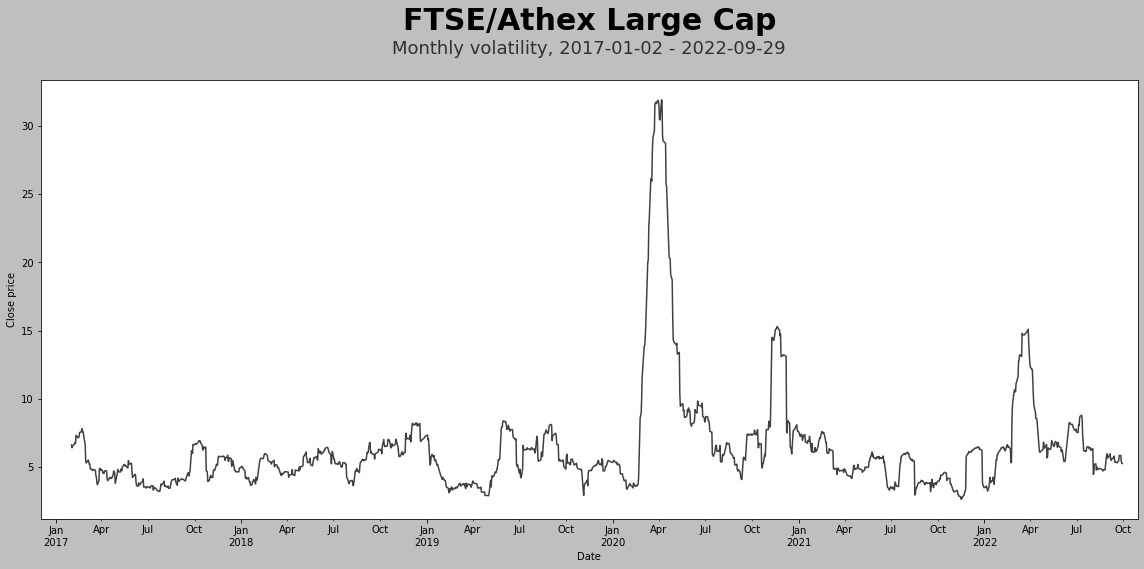

In [ ]:
generatePlot(data['month_vol'], 'Date', 'Percent (%)', 'FTSE/Athex Large Cap', f"Monthly volatility, {datetime.date(data.index.min())} - {datetime.date(data.index.max())}")

## Index constituents overview
Notes:
1.   We consider the same list of 25 constituents over the entire time period. The index is revised on a semiannual basis however with very few changes over the last years (~ 0 -1 changes every review period). The list of announcements with the additions / removals are [here](https://www.athexgroup.gr/el/web/guest/index-information-announcements).
2.   TBD



In [ ]:
ftseStonks = {'ΑΛΦΑ':'ALPHA.AT',
              'ΑΔΜΗΕ':'ADMIE.AT',
              'ΑΡΑΙΓ':'AEGN.AT',
              'ΜΠΕΛΑ':'BELA.AT',
              'ΠΕΙΡ':'TPEIR.AT',
              'ΔΕΗ':'PPC.AT',
              'ΕΕΕ':'EEE.AT',
              'ΕΛΧΑ':'ELHA.AT',
              'ΕΥΡΩΒ':'EUROB.AT',
              'ΕΥΔΑΠ':'EYDAP.AT',
              'ΕΛΛΑΚΤΩΡ':'ELLAKTOR.AT',
              'ΕΛΠΕ':'ELPE.AT',
              'ΓΕΚΤΕΡΝΑ':'GEKTERNA.AT',
              'ΚΟΥΕΣ':'QUEST.AT',
              'ΛΑΜΔΑ':'LAMDA.AT',
              'ΜΟΗ':'MOH.AT',
              'ΜΥΤΙΛ':'MYTIL.AT',
              'ΕΤΕ':'ETE.AT',
              'ΟΛΠ':'PPA.AT',
              'ΟΠΑΠ':'OPAP.AT',
              'ΟΤΕ':'HTO.AT',
              'ΣΑΡ':'SAR.AT',
              'ΤΕΝΕΡΓ':'TENERGY.AT',
              'TITC':'TITC.AT',
              'ΒΙΟ':'VIO.AT'}

In [ ]:
# we are interested only in the closing price, we fetch the last three years worth of data (practially right before the COVID crash).
tickers = yf.Tickers(list(ftseStonks.values()))
data = tickers.download(period='3y',interval='1d', actions=True,auto_adjust=True)['Close']

[*********************100%***********************]  25 of 25 completed


In [ ]:
# have a look at a sample of the stocks
data.tail(5)

,ADMIE.AT,AEGN.AT,ALPHA.AT,BELA.AT,EEE.AT,ELHA.AT,ELLAKTOR.AT,ELPE.AT,ETE.AT,EUROB.AT,...,MYTIL.AT,OPAP.AT,PPA.AT,PPC.AT,QUEST.AT,SAR.AT,TENERGY.AT,TITC.AT,TPEIR.AT,VIO.AT
Date,,,,,,,,,,,,,,,,,,,,,
2022-09-26,1.690,4.675,0.8470,13.50,21.850000,1.360,1.582,6.05,3.028,0.8702,...,13.47,12.15,14.20,5.280,4.050,5.80,15.440000,10.76,1.1055,3.405
2022-09-27,1.662,4.600,0.8470,13.42,22.049999,1.370,1.584,6.10,3.090,0.8802,...,13.67,12.13,14.12,5.320,4.070,6.00,16.299999,10.82,1.1075,3.460
2022-09-28,1.670,4.485,0.8400,13.70,21.150000,1.368,1.570,6.14,3.008,0.8600,...,13.56,12.14,14.00,5.280,4.120,6.02,16.480000,10.80,1.0700,3.390
2022-09-29,1.630,4.450,0.8216,13.96,21.100000,1.320,1.580,6.25,3.030,0.8522,...,13.90,12.01,13.90,5.165,4.125,6.00,16.350000,10.70,1.0300,3.390
2022-09-30,1.620,4.420,0.8060,13.65,21.100000,1.340,1.594,6.26,3.026,0.8560,...,13.99,12.28,13.88,5.200,4.180,6.09,16.500000,10.84,1.0370,3.385


In [ ]:
def calculateAverages(dataset, dateFrom, indicator, span):
    # stack to multi index
    t = dataset.stack()    

    # rename 'value' column
    t.name = 'Close'

    # save series to data frame
    t = t.to_frame()

    # calculate indicator
    t2 = t.groupby(level = 1).apply(lambda x: x.ewm(span = span).mean())

    # merge dataframes
    t3 = pd.merge(t, t2, left_index=True, right_index=True)

    # unstack
    t4 = t3.reset_index(level = [0,1])

    # create bool column to store whether price is above ema50
    comparison_column = np.where(t4["Close_y"] < t4["Close_x"], True, False)
    t4["above"] = comparison_column

    # delete "Close_y" and "Close_X" prices as we don't need them - they store the actual close price and the EMA50 price
    del t4["Close_x"]
    del t4["Close_y"]

    # group by date
    t4 = t4.groupby('Date')['above'].mean()*100

    #t4.name = 'stocks above ' + indicator+ str(span)

    # save series to data frame
    t4 = t4.to_frame()

    # keep data from 01/01/2020 and beyond
    t4 = t4[t4.index > dateFrom] #'2020-01-01'
    
    # return resulting dataframe
    return t4

In [ ]:
df2 = calculateAverages(data, '2020-01-01', 'ewm', 200)

,above
Date,
2020-01-02,100.0
2020-01-03,80.0
2020-01-07,88.0
2020-01-08,72.0
2020-01-09,76.0
...,...
2022-09-26,8.0
2022-09-27,16.0
2022-09-28,12.0


In [ ]:
df1 = calculateAverages(data, '2020-01-01', 'ewm', 50)

,above
Date,
2020-01-02,100.0
2020-01-03,80.0
2020-01-07,88.0
2020-01-08,64.0
2020-01-09,80.0
...,...
2022-09-26,4.0
2022-09-27,8.0
2022-09-28,4.0


In [ ]:
frames = [df1, df2]

In [ ]:
df3 = pd.concat(frames)

,above
Date,
2020-01-02,100.0
2020-01-03,80.0
2020-01-07,88.0
2020-01-08,64.0
2020-01-09,80.0
...,...
2022-09-26,8.0
2022-09-27,16.0
2022-09-28,12.0
